In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

tf.keras.backend.set_floatx('float64')


In [2]:
class Simulation:
    """Sets up a simulation with a specified transition matrix, reward
    matrix, set of allowed actions, and policy. Running the simulation is
    performed with the run_episodes() method.

    Policies provided to the Simulation must implement two methods:
    - choose_action(episode_num, state)
    - update_rewards(episode_num, reward)
    """
    def __init__(self, transitions, rewards, actions, policy):
        """Initialize the Simulation parameters."""
        self.transitions = transitions
        self.rewards = rewards
        self.actions = actions

        self.policy = policy
        self.recorded = {
            "states": [],
            "actions": [],
            "states_after": [],
            "rewards": []
        }

    def run_episode(self, episode_num):
        """Runs a single episode, sending the state (obs) to the policy
        to select an action.
        """
        rewards = 0
        obs = [0]  # in this simulation, everyone starts in same state
        action = self.policy.choose_action(episode_num, np.array(obs))
        obs_after, reward = self._step(action)
        rewards += reward
        self.policy.update_rewards(episode_num, reward)

        # record results
        self.recorded["states"].append(obs)
        self.recorded["actions"].append(action)
        self.recorded["states_after"].append(obs_after)
        self.recorded["rewards"].append(reward)

    def run_episodes(self, num_episodes):
        """Runs a set of episodes."""
        for episode in range(num_episodes):
            if (episode+1) % 100 == 0:
                print(f"Episode: {episode+1}")
            self.run_episode(episode)
        return self.recorded

    def _step(self, action):
        """After an action is chosen, this method selects a transition
        from the transition matrix and returns the new state and the
        associated reward."""
        if action not in self.actions:
            print(f"Error: action {action} not in list of possible actions")

        obs = np.random.choice(len(self.transitions[action]),
            p=self.transitions[action])
        return obs, self.rewards[action][obs]


In [3]:
class RandomPolicy:
    """Chooses an action at random."""
    def __init__(self, possible_actions):
        self.possible_actions = possible_actions

    def choose_action(self, episode_num, obs):
        return np.random.choice(self.possible_actions)

    def update_rewards(self, episode_num, reward):
        pass


In [4]:
class DQN_Policy:
    """A policy for a simple on-policy DQN model."""
    def __init__(self, input_shape, possible_actions, layer_sizes,
                 activation, optimizer, loss_fn, episodes_per_update=10, discount_factor=0.95):
        """Initializes the DQN model.

        Parameters:
        input_shape: List or numpy array of the shape of the inputs
            (state).
        possible_actions: List of labels for possible actions. This
            specifies the shape of the output for the model.
        layer_sizes: List of integers, with each integer indicating the
            size of one hidden layer in the model.
        activation: Activation to use for each hidden layer.
        optimizer: Optimizer to use.
        loss_fn: Loss function to use.
        episodes_per_update: How many episodes to batch before performing
            an single step of gradient descent.
        discount_factor: How much to discount predicted future rewards
            (from 0 to 1).
        """
        self.actions = possible_actions

        self.model = keras.models.Sequential()
        for i, layer in enumerate(layer_sizes):
            if i == 0:
                self.model.add(keras.layers.Dense(
                    layer,
                    activation=activation,
                    input_shape=input_shape))
            else:
                self.model.add(keras.layers.Dense(
                    layer, activation=activation))
        self.model.add(keras.layers.Dense(
            len(self.actions), activation="softmax"))
        self.optimizer = optimizer
        self.loss_fn = loss_fn

        self.episodes_per_update = episodes_per_update
        self.discount_factor = discount_factor

        self.training = True
        self.rewards = []
        self.grads = []
        self.loss = []
 
    def _act(self, obs):
        """Uses model to predict optimal action and selects action.
        Returns both selected action, and probabilities for each action.
        """
        action_probs = self.model(np.array(obs)[np.newaxis])
        action = np.argmax(action_probs)
        return action, action_probs

    def choose_action(self, episode_num, obs):
        """Called by Simulation. Uses model to predict optimal action,
        and calculates loss and gradients for that action.
        """
        if self.training:
            with tf.GradientTape() as tape:
                action, action_probs = self._act(obs)
                y_target = tf.one_hot(action, depth=len(self.actions))
                loss = tf.reduce_mean(self.loss_fn(y_target, action_probs))
                self.loss.append(loss)

            self.grads.append(tape.gradient(loss,
                self.model.trainable_variables))
        else:
            action, _ = self._act(obs)
        return int(action)

    def update_rewards(self, episode_num, reward):
        """Called by Simulation. Given the reward that resulted from
        the action taken, this keeps track of reward and (every
        `episodes_per_update`) takes a step of gradient descent.
        """
        if self.training:
            self.rewards.append(reward)

        if (episode_num+1) % self.episodes_per_update == 0:
            self._update_gradients()

    def _discount_rewards(self, rewards):
        """Calculates discounted rewards for an episode, given
        `discount_factor`.
        """
        discounted = np.array(rewards)
        for step in range(len(rewards) - 2, -1, -1):  # backwards
            discounted[step] += discounted[step + 1] * self.discount_factor
        return discounted

    def _discount_normalize_rewards(self):
        """Calculates discounted rewards and normalizes them, which
        helps to stabilize learning."""
        # all_discounted = self._discount_rewards(self.rewards)
        # we don't want to discount because we only have one step per episode
        all_discounted = np.array(self.rewards)
        reward_mean = all_discounted.mean()
        reward_std = all_discounted.std()
        return [(d - reward_mean) / reward_std for d in all_discounted]

    def _update_gradients(self):
        """Performs a step of gradient descent, using discounted and
        normalized rewards.
        """
        all_final_rewards = self._discount_normalize_rewards()
        all_mean_grads = []
        for var_index in range(len(self.model.trainable_variables)):
            mean_grads = tf.math.reduce_mean(
                [final_reward * self.grads[ep_idx][var_index] for ep_idx, final_reward in enumerate(all_final_rewards)], axis=0)
            all_mean_grads.append(mean_grads)
        self.optimizer.apply_gradients(
            zip(all_mean_grads, self.model.trainable_variables))
        self.rewards = []
        self.grads = []


In [5]:
# three states:
# 0: view signup page with button
# 1: not signed up (terminal)
# 2: signed up (terminal)

# two actions:
# 0: show button 1
# 1: show button 2

# for state 0:
# [a0->s0, a0->s1, a0->s2], [a1->s0, a1->s1, a1->s2]
trans_mtx = np.array([[0, 0.8, 0.2], [0, 0.6, 0.4]])
reward_mtx = np.array([[0, 0, +1], [0, 0, +1]])
possible_actions = [0, 1]


In [6]:
# try a random policy first
rand_policy = RandomPolicy(possible_actions)
rand_policy_sim = Simulation(trans_mtx, reward_mtx,
    possible_actions, rand_policy)
results_rand = rand_policy_sim.run_episodes(1000)

print("Random policy:")
print("Mean: {:.2f}, SD: {:.2f}".format(
    np.mean(results_rand["rewards"]), np.std(results_rand["rewards"])))
print("Min: {:.2f}, Max: {:.2f}".format(
    np.min(results_rand["rewards"]), np.max(results_rand["rewards"])))


Episode: 100
Episode: 200
Episode: 300
Episode: 400
Episode: 500
Episode: 600
Episode: 700
Episode: 800
Episode: 900
Episode: 1000
Random policy:
Mean: 0.33, SD: 0.47
Min: 0.00, Max: 1.00


In [7]:
# try a DQN policy
lr_schedule = keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.001,
    decay_steps=5000,
    decay_rate=0.5,
    staircase=False)

dqn_policy = DQN_Policy(
    input_shape=[1],
    possible_actions=possible_actions,
    layer_sizes=[8],
    activation="relu",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    loss_fn=keras.losses.categorical_crossentropy,
    episodes_per_update=10)
dqn_policy_sim = Simulation(trans_mtx, reward_mtx,
    possible_actions, dqn_policy)
results_dqn = dqn_policy_sim.run_episodes(5000)

print("DQN policy:")
print("Mean: {:.2f}, SD: {:.2f}".format(
    np.mean(results_dqn["rewards"]), np.std(results_dqn["rewards"])))
print("Min: {:.2f}, Max: {:.2f}".format(
    np.min(results_dqn["rewards"]), np.max(results_dqn["rewards"])))


Episode: 100
Episode: 200
Episode: 300
Episode: 400
Episode: 500
Episode: 600
Episode: 700
Episode: 800
Episode: 900
Episode: 1000
Episode: 1100
Episode: 1200
Episode: 1300
Episode: 1400
Episode: 1500
Episode: 1600
Episode: 1700
Episode: 1800
Episode: 1900
Episode: 2000
Episode: 2100
Episode: 2200
Episode: 2300
Episode: 2400
Episode: 2500
Episode: 2600
Episode: 2700
Episode: 2800
Episode: 2900
Episode: 3000
Episode: 3100
Episode: 3200
Episode: 3300
Episode: 3400
Episode: 3500
Episode: 3600
Episode: 3700
Episode: 3800
Episode: 3900
Episode: 4000
Episode: 4100
Episode: 4200
Episode: 4300
Episode: 4400
Episode: 4500
Episode: 4600
Episode: 4700
Episode: 4800
Episode: 4900
Episode: 5000
DQN policy:
Mean: 0.19, SD: 0.39
Min: 0.00, Max: 1.00


In [8]:
def moving_average(a, n=5):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


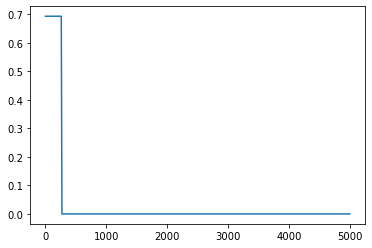

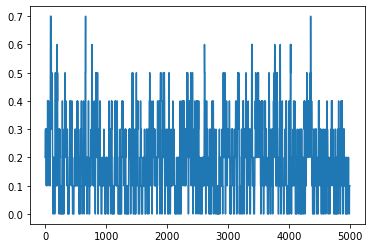

In [9]:
dqn_loss_mv_avg = moving_average(dqn_policy.loss, n=10)
plt.plot(range(len(dqn_loss_mv_avg)), dqn_loss_mv_avg)
plt.show()

dqn_rew_mv_avg = moving_average(results_dqn["rewards"], n=10)
plt.plot(range(len(dqn_rew_mv_avg)), dqn_rew_mv_avg)
plt.show()

# So I'm having a lot of difficulty finding a good learning rate, etc. that
# doesn't lead to eventual "nan" values that then make the loss drop to
# zero. Some of the instability might be a result of the model literally
# getting the exact same input every time. But I don't think that fully
# explains it.



In [10]:
# let's try something a little more interesting...
# same three states, but in addition, we have information about
# the user's gender and age

# two actions:
# 0: show button 1
# 1: show button 2

# probability of signing up depends on following function:
# norm_age = (age - 18) / (65 - 18)
# alpha = (-0.3) + (-0.4)*button + (-0.2)*female + 0.4*female*button + 0.8*norm_age + 0.4*norm_age*button
# y = 1 / (1 + exp(-alpha))
# (works out to a range of about 35% to 80%, from ages 20 to 70)

def transition_fn(state, action):
    gender = state[1]
    age = state[2]
    alpha = (-0.7) + (-0.4)*action + (-0.2)*gender + 0.4*gender*action + 0.02*age + 0.01*age*action
    return 1 / (1 + np.exp(-alpha))

rewards = [0, 0, +1]
possible_actions = [0, 1]


In [11]:
class SimulationWithFunc:
    """Sets up a simulation with a specified transition matrix, reward
    matrix, set of allowed actions, and policy. Running the simulation is
    performed with the run_episodes() method.

    Policies provided to the Simulation must implement two methods:
    - choose_action(episode_num, state)
    - update_rewards(episode_num, reward)
    """
    def __init__(self, transition_fn, rewards, actions, policy):
        """Initialize the Simulation parameters."""
        self.transition_fn = transition_fn
        self.rewards = rewards
        self.actions = actions

        self.policy = policy
        self.recorded = {
            "states": [],
            "actions": [],
            "states_after": [],
            "rewards": []
        }
 
    def _get_state(self):
        """Randomly selects a gender (0 or 1) and age (between 18 and 65)
        from a uniform distribution. Age is normalized. Returns the
        initial state for an episode.
        """
        gender = np.random.choice([0, 1])
        age = np.random.choice(range(18, 65))
        norm_age = (age - 18) / (65 - 18)
        return np.array([0, gender, norm_age])
 
    def run_episode(self, episode_num):
        """Runs a single episode, sending the state (obs) to the policy
        to select an action.
        """
        rewards = 0
        obs = self._get_state()
        action = self.policy.choose_action(episode_num, obs)
        obs_after, reward = self._step(obs, action)
        rewards += reward
        self.policy.update_rewards(episode_num, reward)

        # record results
        self.recorded["states"].append(obs)
        self.recorded["actions"].append(action)
        self.recorded["states_after"].append(obs_after)
        self.recorded["rewards"].append(reward)
 
    def run_episodes(self, num_episodes):
        """Runs a set of episodes."""
        for episode in range(num_episodes):
            if (episode+1) % 100 == 0:
                print(f"Episode: {episode+1}")
            self.run_episode(episode)
        return self.recorded
 
    def _step(self, state, action):
        """After an action is chosen, this method selects a transition
        from the transition matrix and returns the new state and the
        associated reward."""
        if action not in self.actions:
            print(f"Error: action {action} not in list of possible actions")

        prob = self.transition_fn(state, action)
        obs = np.random.choice([1, 2], p=[(1-prob), prob])
        new_state = state.copy()
        new_state[0] = obs
        return new_state, self.rewards[obs]


In [12]:
# try a random policy
rand_policy = RandomPolicy(possible_actions)
rand_policy_sim = SimulationWithFunc(transition_fn, rewards,
    possible_actions, rand_policy)
results_rand = rand_policy_sim.run_episodes(1000)

print("Random policy:")
print("Mean: {:.2f}, SD: {:.2f}".format(
    np.mean(results_rand["rewards"]), np.std(results_rand["rewards"])))
print("Min: {:.2f}, Max: {:.2f}".format(
    np.min(results_rand["rewards"]), np.max(results_rand["rewards"])))


Episode: 100
Episode: 200
Episode: 300
Episode: 400
Episode: 500
Episode: 600
Episode: 700
Episode: 800
Episode: 900
Episode: 1000
Random policy:
Mean: 0.30, SD: 0.46
Min: 0.00, Max: 1.00


In [13]:
# try a DQN policy
lr_schedule = keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.01,
    decay_steps=5000,
    decay_rate=0.5,
    staircase=False)

dqn_policy = DQN_Policy(
    input_shape=[3],
    possible_actions=possible_actions,
    layer_sizes=[8],
    activation="elu",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    loss_fn=keras.losses.categorical_crossentropy,
    episodes_per_update=20)
dqn_policy_sim = SimulationWithFunc(transition_fn, rewards,
    possible_actions, dqn_policy)
results_dqn = dqn_policy_sim.run_episodes(5000)

print("DQN policy:")
print("Mean: {:.2f}, SD: {:.2f}".format(
    np.mean(results_dqn["rewards"]), np.std(results_dqn["rewards"])))
print("Min: {:.2f}, Max: {:.2f}".format(
    np.min(results_dqn["rewards"]), np.max(results_dqn["rewards"])))


Episode: 100
Episode: 200
Episode: 300
Episode: 400
Episode: 500
Episode: 600
Episode: 700
Episode: 800
Episode: 900
Episode: 1000
Episode: 1100
Episode: 1200
Episode: 1300
Episode: 1400
Episode: 1500
Episode: 1600
Episode: 1700
Episode: 1800
Episode: 1900
Episode: 2000
Episode: 2100
Episode: 2200
Episode: 2300
Episode: 2400
Episode: 2500
Episode: 2600
Episode: 2700
Episode: 2800
Episode: 2900
Episode: 3000
Episode: 3100
Episode: 3200
Episode: 3300
Episode: 3400
Episode: 3500
Episode: 3600
Episode: 3700
Episode: 3800
Episode: 3900
Episode: 4000
Episode: 4100
Episode: 4200
Episode: 4300
Episode: 4400
Episode: 4500
Episode: 4600
Episode: 4700
Episode: 4800
Episode: 4900
Episode: 5000
DQN policy:
Mean: 0.31, SD: 0.46
Min: 0.00, Max: 1.00


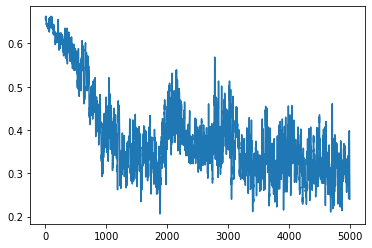

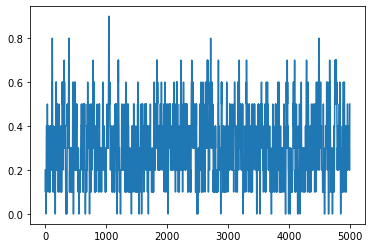

In [14]:
dqn_loss_mv_avg = moving_average(dqn_policy.loss, n=10)
plt.plot(range(len(dqn_loss_mv_avg)), dqn_loss_mv_avg)
plt.show()

dqn_rew_mv_avg = moving_average(results_dqn["rewards"], n=10)
plt.plot(range(len(dqn_rew_mv_avg)), dqn_rew_mv_avg)
plt.show()

# the loss looks a little better at least, but I don't see any real
# improvement in the reward